## What is radial distortion?

Real cameras with real optics suffer from radial distortion. 
Radial distortion is a common type of [lens distortion](https://en.wikipedia.org/wiki/Distortion_(optics)). It's a deviation away from a perfect pinhole camera, where straight lines in 3D space are mapped to straight lines in 2D space. Let's define this distortion mathematically.


## Defining a forward function

Radial distortion functions map points according to their distance (r) from the optical centre of the lens.

We can model the function using a [Taylor series](https://en.wikipedia.org/wiki/Taylor_series):

$\begin{equation*}
x_d = x(1 + k_1  r + k_2  r^2 + k_3 r^3)
\end{equation*}$

$\begin{equation*}
y_d = y(1 + k_1  r + k_2 r^2 + k_3 r^3)
\end{equation*}$

I.e., the function is described using three numbers, k_1, k_2 and k_3.

Firstly, let's import some things we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

Next, let's use some distortion coefficients from an actual lens and plot how it maps points based on their radius from the optical centre of the lens.

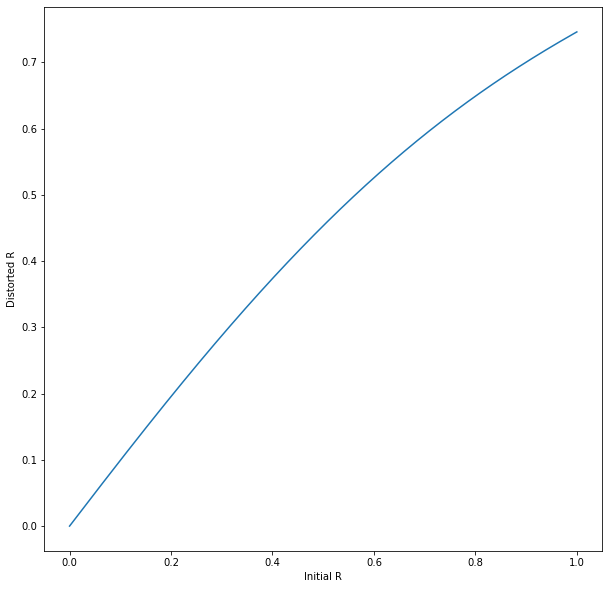

In [2]:
k_1 = -0.04436
k_2 = -0.35894
k_3 =  0.14944

r = np.linspace(0,1,1000)
r_distorted = r*(1 + k_1 * r + k_2 * r**2 + k_3 * r**3)

plt.xlabel('Initial R')
plt.ylabel('Distorted R')
plt.plot(r,r_distorted)
plt.show()

To help understand this mapping, we can visualise the impact on a grid of straight lines. Note how straight lines are mapped to curves.

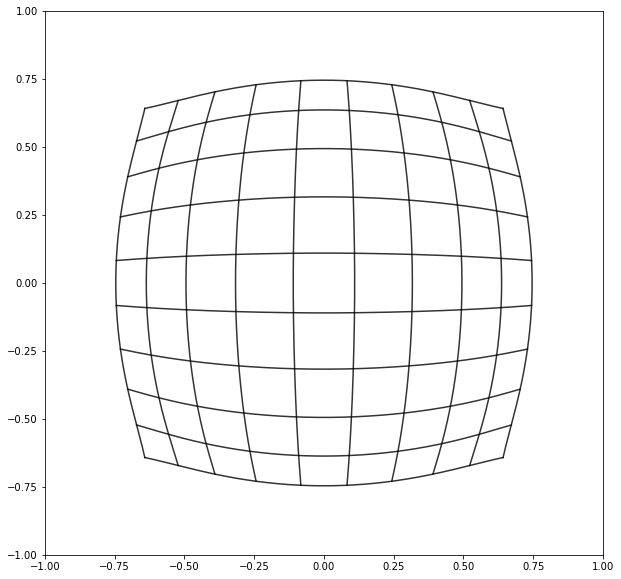

In [3]:
def distort_line(x,y,k_1,k_2,k_3):
    r = np.sqrt(x**2 + y**2)
    x_distorted = x*(1 + k_1 * r + k_2 * r**2 + k_3 * r**3)
    y_distorted = y*(1 + k_1 * r + k_2 * r**2 + k_3 * r**3)
    return(x_distorted,y_distorted)

for y in np.linspace(-1,1,10):
    x = np.linspace(-1,1,1000)
    x_distorted,y_distorted = distort_line(x,y,k_1,k_2,k_3)
    plt.plot(x_distorted,y_distorted,color='k',alpha=0.8)
    
for x in np.linspace(-1,1,10):
    y = np.linspace(-1,1,1000)
    x_distorted,y_distorted = distort_line(x,y,k_1,k_2,k_3)
    plt.plot(x_distorted,y_distorted,color='k',alpha=0.8)
    
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

## Finding an Inverse Function

Now it's time to find an inverse function, a function that will allow us to take points that have been distorted, and map them back to where they would have been, had the lens been free from distortion. 

Unfortunately, we can't find an inverse function based on the forward function algebraically. However, we can find an inverse function through a process of optimization.



In [4]:
def undistort_point(undistortion_params,r_distorted):
    undistorted = r_distorted*(1 + undistortion_params[0] * r_distorted
                               + undistortion_params[1] * r_distorted**2
                               + undistortion_params[2] * r_distorted**3
                               + undistortion_params[3] * r_distorted**4
                               + undistortion_params[4] * r_distorted**5)
    return(undistorted)

def fun(undistortion_params,r_distorted):
    #Compute residuals.
    undistorted = undistort_point(undistortion_params, r_distorted)
    return((undistorted - np.linspace(0,1,1000))).ravel()

In [5]:
x0 = np.zeros(5).ravel()
res = least_squares(fun, x0,  verbose=2, ftol=1e-12,loss='linear', args=([r_distorted]))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.6524e+00                                    3.02e+01    
       1              2         2.3481e-07      5.65e+00       9.82e-01       1.88e-08    
       2              3         2.3481e-07      1.62e-17       1.58e-06       1.04e-11    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 5.6524e+00, final cost 2.3481e-07, first-order optimality 1.04e-11.


The optimisation process tries to find a set of coefficients that allow us to map the output from the distortion function back to its input.

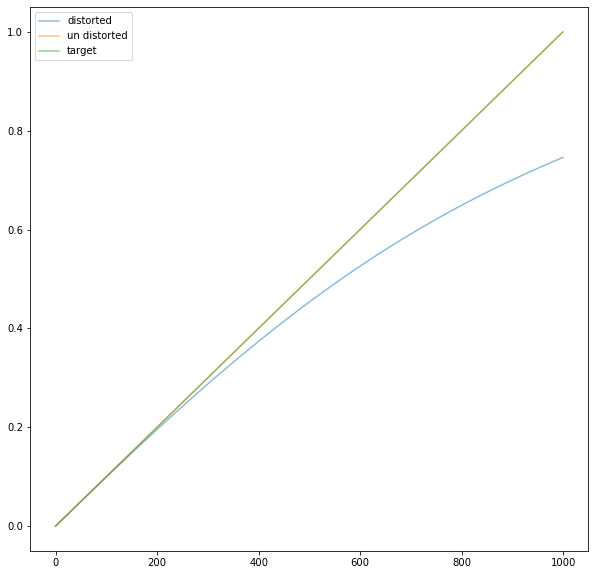

In [8]:
undistorted = undistort_point(res.x,r_distorted)    
plt.plot(r_distorted,label='distorted',alpha=0.5)
plt.plot(undistorted,label='un distorted',alpha=0.5)
plt.plot(np.linspace(0,1,1000),label='target',alpha=0.5)
plt.legend()
plt.show()

In [7]:
print(res.x)

[ 0.04599498  0.32120247  0.22196835 -0.46283148  0.77191211]


Voilà, we have found the coefficients of a Taylor series that allow us to invert the distortion function.